# Milestone Project

The goal is to simulate the quantum adiabatic algorithm solving a small instance of maximum independence set on the graph defined by the adjacency matrix $M$, where

$$ 
M = \begin{pmatrix}
0 & 1 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 \\
0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{pmatrix}  
$$

### Method
1. Construct $H_{\mathrm{Ising}}$ for this graph
2. Verify that the lowest energy state is indeed the maximum independent set $|10011\rangle$, which is represented by a column vector of length $2^5$ with a one in the 19<sup>th</sup> position, and zeros elsewhere
3. Simulate an adiabatic algorithm solving the problem with a time dependent Hamiltonian 


#### Import necessary libraries

In [77]:
import numpy as np
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from functools import partial
from IPython.display import HTML

#### Helper functions

In [3]:
pauli_matrices = {
    'x':np.matrix(([0, 1], [1, 0])),
    'y':np.matrix(([0, -1j], [1j, 0]), dtype=complex),
    'z':np.matrix(([1, 0], [0, -1]))
}

def generate_sigma_j(j: int, axis: str, n:int) -> np.matrix:
    """
    Inputs:
    j: the qubit being operated on
    axis: x, y or z 
    n: number of qubits in the system
    Returns:
    Matrix representation of the axis pauli operation
    on the jth qubit
    """
    # Set pauli matrix according to input axis
    sigma = pauli_matrices[axis]
    
    # Initialise sigma_j as 1
    sigma_j = 1

    # Iterate through to n
    for i in range(n):
        if i == j:
            sigma_j = np.kron(sigma_j, sigma)
        else:
            sigma_j = np.kron(sigma_j, np.identity(2))
    
    return sigma_j

#### 1. Construct $H_{\mathrm{Ising}}$
$$
H_{\mathrm{Ising}} = \sum_{k = 1}^n \sum_{j = k + 1} ^ n J_{kj} \sigma_k^z \sigma_j^z + \sum_{j=1}^n h_j \sigma_j^z,
$$
where $J = M$, and
$$
h_k = -\sum_{j=1}^n(M_{kj} + M_{jk}) + \kappa
$$

In [4]:
def generate_strengths(M: np.matrix, kappa:float) -> tuple[np.matrix, np.ndarray]:
    """
    Inputs are M the adjacancy matrix and kappa the variable that rewards
    more independence
    Returns J and h, the coupling and field strengths respectively
    """
    # Set n to be the number of qubits in the system
    n = M.shape[0]

    # Initialise h as an array of kappas
    h = np.ones((n)) * kappa

    # Generate h - TODO method could probably be vectorised
    for k in range(n):
        for j in range(n):
            h[k] += -(M[k, j] + M[j, k])
    
    return M, h

def construct_H_ising(J: np.ndarray, h: np.ndarray) -> np.matrix:
    """
    Inputs: J and h are the coupling and field strengths respectively
    Returns: The Ising Hamiltonian, a 2^n x 2^n matrix
    """
    n = h.size
    H_ising = np.zeros((2**n, 2**n))

    # Add the first sum
    for k in range(n):
        for j in range(k + 1, n):
            sigma_j = generate_sigma_j(j, 'z', n)
            sigma_k = generate_sigma_j(k, 'z', n)
            H_ising += J[k, j] * sigma_k * sigma_j
    
    # Add the second sum
    for j in range(n):
        sigma_j = generate_sigma_j(j, 'z', n)
        H_ising += h[j] * sigma_j

    return H_ising

##### Test these functions with the example from the project book.

For the three qubit problem defined by the graph represented by the adjacency matrix

$$
M = \begin{pmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 
\end{pmatrix}
$$

we can check if our functions generate the expected Ising Hamiltonian.

In [5]:
kappa_test = 0.5
M_test = np.matrix([
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 0]
])
expected_h_test = np.diag(np.array([
    -2 + 3*kappa_test, 
    -2 + kappa_test,
    -2 + kappa_test, 
    2 - kappa_test,
    -2 + kappa_test,
    -2 - kappa_test,
    2 - kappa_test,
    6 - 3*kappa_test
]))

J_test, h_test = generate_strengths(M_test, kappa_test)

if np.array_equal(h_test, np.array([-0.5, -1.5, -0.5])):
    print("Test 1 passed! Generated correct field strengths.")
else:
    print(f"Test 1 failed, expected\n {np.array([-0.5, -1.5, -0.5])},\n got {h_test}")

my_h_test = construct_H_ising(J_test, h_test)

if np.array_equal(my_h_test, expected_h_test):
    print("Test 2 passed! Generated correct Ising Hamiltonian.")
else:
    print(f"Test failed, expected \n {expected_h_test},\n got \n {my_h_test}.")

Test 1 passed! Generated correct field strengths.
Test 2 passed! Generated correct Ising Hamiltonian.


Assuming they passed, we can generate the project Hamiltonian

In [6]:
kappa = 0.5
M = np.matrix([
    [0, 1, 1, 0, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

J, h = generate_strengths(M, kappa)

H_ising = construct_H_ising(J, h)

H_ising

array([[-3.5,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , -4.5,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -4.5, ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., 12.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  8.5,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 15.5]])

#### 2. Verify correct lowest energy state is in the 19th column


In [7]:
if np.min(H_ising) == H_ising[19][19]:
    print("Lowest energy state is as expected.")
else:
    print("Lowest energy state is not where we expect to find it.")

Lowest energy state is as expected.


#### 3. Simulate an adiabatic algorithm, solving the problem with a time dependent Hamiltonian

First, define the function for the time-dependent Hamiltonian,

$$
H(t) = -A(t) \sum_j \sigma_j^x + B(t)H_{\mathrm{Ising}},
$$

where $A(t) = 1 - t/t_{\mathrm{max}}$ and $B(t) = t/t_{\mathrm{max}}$ are the time-dependent controls.

In [8]:
def time_dependent_H(A: float, B: float, H_ising: np.matrix, n: int) -> np.matrix:
    """
    Inputs:
    A, B: time controls
    H_isising: the problem Hamiltonian
    n: the number of qubits in the system
    """    
    H = B * H_ising

    for j in range(n):
        H -= A * generate_sigma_j(j, 'x', n)
    
    return H

def control_A(t: float, t_max: float) -> float:
    """
    Inputs:
    t: time
    t_max: total runtime of the algorithm
    Return:
    Linear time dependent control
    """
    return 1 - t/t_max

def control_B(t: float, t_max: float) -> float:
    """
    Inputs:
    t: time
    t_max: total runtime of the algorithm
    Return:
    Linear time dependent control
    """
    return t/t_max

Form the initial wavefunction, the ground state of the initial Hamiltonian. Since, at $t = 0$, $B=0$ and $A>0$, the ground state will just be the highest energy state of each $\sigma^x$ individually.
$$
| \phi_0 \left ( A>0, B=0\right)\rangle = \bigotimes _{j=1}^n | + \rangle
$$

In [9]:
def generate_initial_wavefunction(n: int) -> np.ndarray:
    """
    Inputs:
    n: number of qubits
    Returns:
    The ground state of the Hamiltonian at t=0
    """
    phi = 1
    max_state = np.array([[1, 1]]).T / np.sqrt(2)

    for _ in range(n):
        phi = np.kron(phi, max_state)
    
    return phi

In [10]:
n = M.shape[0]
phi_0 = generate_initial_wavefunction(n)

We also need the vector $|19\rangle$ to calculate the probability that our solution is correct

In [11]:
def generate_vector_j(j: int, n: int) -> np.ndarray:
    """
    Returns a column vector with all values 0 except at j where it is 1
    """
    vector = np.zeros((1, 2**n))
    vector[:,j] = 1

    return vector.T

And the time evolution operator

$$
U\left(\frac{k t_\mathrm{max}}{q}, 0\right) = \mathcal{T}\prod_{j=1}^k \exp \left ( -i \frac{t_\mathrm{max}}{q} H \left(\frac{j t_\mathrm{max}}{q}\right) \right)
$$

In [12]:
def time_evolution(t_max: float, q: int, H: np.matrix, phi: np.ndarray) -> np.ndarray:
    """
    Inputs:
    t_max: maximum time for evolution
    q: number of time divisions
    H: time dependent Hamiltonian evaluated at jt_max/q
    phi: current wavefunction
    Returns:
    The time evolved wavefunction
    """

    return np.matmul(sc.linalg.expm(-1j * t_max / q * H), phi)

Now, vary $t$ from $0$ to $t_{\mathrm{max}}$ in $q$ steps. 

In [58]:
def evolve_phi(
        phi: np.ndarray,
        j: int,
        t_max: int,
        q: int
        ) -> list[float]:
    """
    For a given function phi = phi((j - 1) * t_max / q), returns
    phi(j * t_max / q)
    """
    t = j * t_max / q

    A = control_A(t, t_max)
    B = control_B(t, t_max)

    # Generate the Hamiltonian at time t
    H = time_dependent_H(A, B, H_ising, n)

    # Evolve the wavefunction from t -> j * t_max / q
    phi = time_evolution(t_max, q, H, phi)

    return phi

In [14]:
def generate_probabilities(
        q: int, 
        t_max: float, 
        H_ising: np.matrix, 
        n: int, 
        expected_vector: np.ndarray
        ) -> list[float]:
    """
    Inputs:
    q: the number of time increments
    t_max: the maximum time
    H_ising: the problem Hamilonian
    n: the number of qubits
    expected_vector: the ground state of the problem Hamiltonian
    Returns:
    A list of the probabilities that the system has the expected wavefunction
    for times t in [0, t_max]  
    """
    probs = []
    phi = phi_0

    for j in range(q):
        phi = evolve_phi(phi, j, t_max, q)

        # Calculate the probability that phi represents the expected vector_19
        prob = (np.abs(np.dot(phi.T, expected_vector))**2)[0][0] 

        probs.append(prob)
    
    return probs

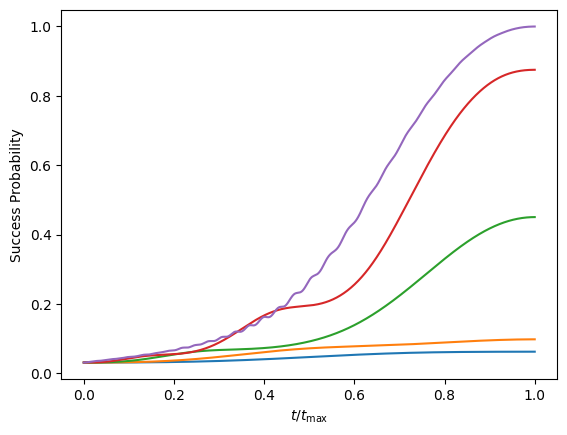

In [52]:
q = 1000
t_maxs = [1, 2, 5, 10, 100]
# t_maxs=[100]
vector_19 = generate_vector_j(19, n)

for t_max in t_maxs:
    probs = generate_probabilities(q, t_max, H_ising, n, vector_19)

    times = np.linspace(0, 1, q)
    plt.plot(times, probs)

font = {'fontname' : 'Helvetia'}

plt.xlabel(r'$t/t_{\mathrm{max}}$')
plt.ylabel('Success Probability', **font)
plt.savefig('milestone.png', transparent=True)

### Superposition animation

Define the basis matrix $B$

In [18]:
B = np.identity(2**n)

Create plot

0
0
100
200
300
400
500
600
700
800
900


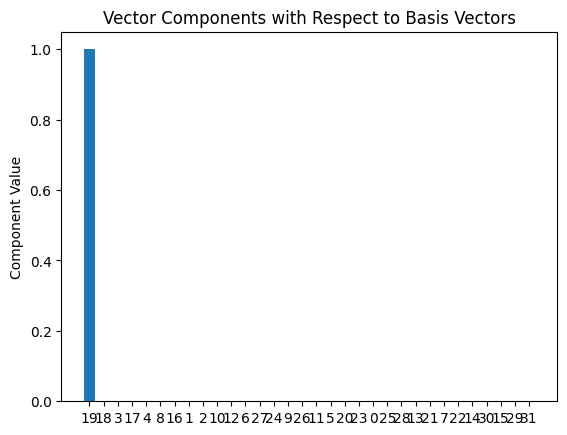

In [80]:
fig, ax = plt.subplots()
ax.set_ylabel('Component Value')
ax.set_title('Vector Components with Respect to Basis Vectors')

t_max = 100
q = 1000
phi = generate_initial_wavefunction(n)

def update(j, t_max, q):
    if j % 100 == 0:
        print(j)

    ax.clear()

    # Calculate phi in this frame
    global phi
    phi = evolve_phi(phi, j, t_max, q)

    # Calculate the projection of phi in the basis B
    projections = ((np.abs(np.dot(phi.T, B)))**2)[0]

    sorted_indices = np.argsort(projections)[::-1]
    projections = projections[sorted_indices]

    ax.bar(range(len(projections)), projections)
    ax.set_xticks(range(len(projections)))
    ax.set_xticklabels([i for i in sorted_indices])
    ax.set_ylabel('Component Value')
    ax.set_title('Vector Components with Respect to Basis Vectors')

anim = FuncAnimation(
    fig, 
    partial(update, t_max=t_max, q=q),
    frames=np.arange(0, q, 1), 
    interval=30,
    )

# Set higher memory limit
matplotlib.rcParams['animation.embed_limit'] = 2**128

writergif = animation.PillowWriter(fps=30)
anim.save('filename.gif',writer=writergif)

# HTML(animation.to_jshtml())

## Poster ideas

- Could add a QR code leading to a gif of a bar chart of how the superposition states vary with time
- Make graph look nicer 
- Talk more directly about results, what does the graph mean, what does success probability mean etc.